# Algoritmo de inferencia del peso $W$

A partir de los estudios matematicos realizados en los capítulos anteriores podemos desarrollar un *pipeline* que dados los valores de longitud $L$ y anchura $A$ de un lenguado obtenidos por medición directa o mediante visión artificial obtengamos el peso estimado. La trasnformada logaritmica produce una normalización de la distribución sesgada del peso y una linealización de las relaciones exponenciales de Peso vs. Longitud y Peso vs. Anchura, lo que nos permite usar el método `LinearRegression` de la librería `scikit-learn`. Esta librería ofrece implementaciones listas para usar de los algoritmos más frecuentes en clasificación, regresión, clustering, reducción de dimensión, validación de modelos y preprocesado, todo ello bajo una API unificada que se resume en los métodos fit, predict y transform. Esta coherencia facilita encadenar pasos mediante *pipelines*, realizar búsquedas de hiperparámetros y/o estimar el error de generalización.

En aprendizaje automático, el **error de generalización** (también denominado *riesgo esperado*) es la discrepancia estadística entre las predicciones de un modelo y los valores reales que se observarían si el modelo se aplicase a todo el universo de datos posibles, no sólo a la muestra con la que fue entrenado. Este error uede estimarse empíricamente y, a la vez, reducirse mediante validación cruzada K-Fold. Esta técnica particiona aleatoriamenteel conjunto de datos en $K$ pliegues de tamaño similar, cada iteración reserva un pliegue como “muestra externa” y entrena el modelo con los $K – 1$ restantes, de modo que todas las observaciones se emplean sucesivamente como datos no vistos; el promedio de la métrica sobre los $K$ ciclos proporciona una estimación casi insesgada del riesgo esperado y presenta menor varianza que un único *hold-out*. Además, esa estructura repetida permite comparar hiperparámetros, arquitecturas o transformaciones y seleccionar la configuración que minimiza la pérdida promedio en los pliegues, lo cual actúa como un proceso de regularización implícita que atenúa el sobreajuste y, por ende, disminuye el error de generalización del modelo final entrenado con el conjunto completo.

`````{admonition} ¿Que és *hold-out?*
:class: tip
En aprendizaje automático, un *hold-out* es una estrategia de validación que consiste en apartar de forma permanente una fracción del dataset —típicamente entre el 20 % y el 30 %— para usarla exclusivamente como conjunto de prueba (test set). El resto de las observaciones se emplea para entrenar el modelo (y opcionalmente para ajustar hiperparámetros mediante un subconjunto de validación interno). Durante el entrenamiento el modelo nunca “ve” los datos del *hold-out*; así, el rendimiento calculado sobre ese bloque reservado ofrece una estimación objetiva de su capacidad de generalizar a datos completamente nuevos. El método es sencillo y eficiente cuando se dispone de un volumen de datos muy grande, pero puede ser inestable en muestras moderadas o pequeñas, ya que la estimación depende fuertemente de cómo se haya realizado la partición; por esa razón suele sustituirse o complementarse con técnicas más robustas como la validación cruzada K-Fold.
`````

Modelo alométrico:  W = 0.03904 · L^1.895 · A^1.009
R² (entrenamiento): 0.9722
R² (5-fold CV):     0.9654
RMSE log-espacio (CV): 0.1109
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3568.
Date:                Mon, 30 Jun 2025   Prob (F-statistic):          1.93e-159
Time:                        13:30:55   Log-Likelihood:                 177.68
No. Observations:                 207   AIC:                            -349.4
Df Residuals:                     204   BIC:                            -339.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.

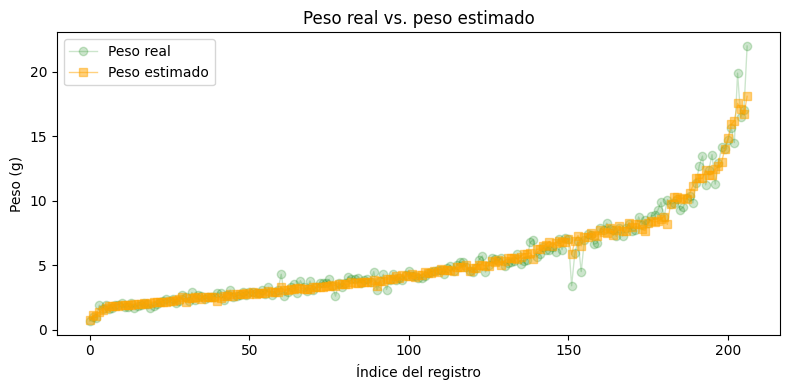

In [1]:
# ==============================
# 1. CARGA DE LIBRERÍAS
# ==============================
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.api as sm            # para diagnóstico opcional
import matplotlib.pyplot as plt

# ==============================
# 2. LECTURA DEL DATASET + LIMPIEZA
# ==============================
df = pd.read_excel('.././data/Dimensiones_lenguado.xlsx')

# Eliminamos los outliers detectados con IQR, Z-Score e Isolation Forest
df = df.drop(index=[0, 1]).reset_index(drop=True)

# Renombramos columnas a algo más manejable
df = df.rename(columns={
    'Peso (g)': 'W',
    'Longitud (cm)': 'L',
    'Anchura (cm)': 'A'
})

# ==============================
# 3. TRANSFORMACIÓN LOGARÍTMICA
#    ln(W) = ln(k) + a·ln(L) + b·ln(A)
# ==============================
df['lnW'] = np.log(df['W'])
df['lnL'] = np.log(df['L'])
df['lnA'] = np.log(df['A'])

X = df[['lnL', 'lnA']].values          # variables predictoras
y = df['lnW'].values                   # variable respuesta

# ==============================
# 4. AJUSTE DEL MODELO
# ==============================
linreg = LinearRegression().fit(X, y)
a, b       = linreg.coef_              # exponentes
ln_k       = linreg.intercept_         # ln(k)
k          = np.exp(ln_k)              # constante de proporcionalidad
r2_train   = linreg.score(X, y)

# ==============================
# 5. VALIDACIÓN CRUZADA (5-fold)
# ==============================
kf      = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv   = cross_val_score(linreg, X, y, cv=kf, scoring='r2').mean()
rmse_cv = -cross_val_score(
    linreg, X, y,
    cv=kf,
    scoring=make_scorer(
        lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
    )
).mean()

# ==============================
# 6. RESULTADOS
# ==============================
print(f"Modelo alométrico:  W = {k:.5f} · L^{a:.3f} · A^{b:.3f}")
print(f"R² (entrenamiento): {r2_train:.4f}")
print(f"R² (5-fold CV):     {r2_cv:.4f}")
print(f"RMSE log-espacio (CV): {rmse_cv:.4f}")

# ==============================
# 7. DIAGNÓSTICO OPCIONAL (Statsmodels)
# ==============================
X_sm = sm.add_constant(df[['lnL', 'lnA']])
ols   = sm.OLS(y, X_sm).fit()
print(ols.summary())


# ==============================
# 8. FUNCIÓN INFERENCIA
# =============================

def estimate_weight(L_cm: float, A_cm: float) -> float:
    """
    Devuelve el peso estimado (gramos) a partir de la longitud (L_cm)
    y la anchura (A_cm) usando el modelo W = k·L^a·A^b.
    """
    ln_hatW = ln_k + a * np.log(L_cm) + b * np.log(A_cm)
    return (np.exp(ln_hatW))

    
# ==============================
# 9. GRÁFICAS REAL vs. ESTIMADO
# =============================

# Pesos real y estimado en el orden del índice
W_real = df['W'].values
W_pred = estimate_weight(df['L'].values, df['A'].values)

plt.figure(figsize=(8, 4))
plt.plot(
    W_real,
    label='Peso real',
    marker='o',
    lw=1,
    color='green',    # color solicitado
    alpha=0.2         # transparencia solicitada
)
plt.plot(W_pred, label='Peso estimado', marker='s', lw=1, color='orange', alpha=0.5)
plt.ylabel('Peso (g)')
plt.xlabel('Índice del registro')
plt.title('Peso real vs. peso estimado')
plt.legend()
plt.tight_layout()
plt.show()



## Resultados

El modelo obtenido ajusta un 97 % de la variabilidad del peso, con coeficientes altamente significativos y un ajuste global validado por un F-statistic muy elevado. El diagnóstico de residuos —la diferencia entre lo que el modelo predice y el dato observado— revela un ajuste cuantitativamente sólido pero con ligeras desviaciones respecto a los supuestos clásicos. 

El estadístico Durbin–Watson nos indica la independencia entre errores consecutivos. Este parámetro oscila entre 0 y 4, siendo el valor de 2 indicativo de un comportamiento ideal. Un 1.88 está tan cerca de 2 que podemos decir que no hay correlación apreciable entre errores. En lo que respecta a la forma en la que se distribuyen los errores, los tests Omnibus y Jarque–Bera (p ≈ 0) señalan que los residuos no son estrictamente normales, existiendo algo más de casos con errores grandes por debajo de lo esperado (Skew < 0) con más valores extremos de los normal (Kurtois > 3). 

Por otro lado,  el número de condición (Cond. No.) 60.2 indica colinealidad entre predictores moderada. Como es normal en peces, la longitud $L$ y la anchura $A$ son parámetros muy interrelacionamos en peces. El valor obtenido con este estadístico refleja justamente la existencia de correlacion que no compromete la predicción pero puede inflar la varianza de los coeficientes.

En líneas generales el modelo es muy bueno explicando el peso a partir de las variables morfologicas. Para usos prácticos de predicción, las pequeñas desviaciones de normalidad no son un problema. A efectos prácticos una cuantificacion de la biomasa total del dataset observado vs. estimado arroja unos datos de 1117,03 g. y de 1109,92 g. respectivamente, lo cual indica que el algoritmo es capaz de ajustar la biomasa total de la muestra observada con una certeza del 99,34%.